Quickstart
======

In [10]:
%matplotlib inline
import os
import tempfile

import scipy.stats as st

from pyabc import (ABCSMC, RV, Distribution,
                   PercentileDistanceFunction)

# Define a gaussian model
sigma = .5


def model(parameters):
    # sample from a gaussian
    y = st.norm(parameters.x, sigma).rvs()
    # return the sample as dictionary
    return {"y": y}

In [11]:
# We define two models, but they are identical so far
models = [model, model]


# However, our models' priors are not the same.
# Their mean differs.
mu_x_1, mu_x_2 = 0, 1
parameter_priors = [
    Distribution(x=RV("norm", mu_x_1, sigma)),
    Distribution(x=RV("norm", mu_x_2, sigma))
]

In [12]:
# We plug all the ABC options together
abc = ABCSMC(
    models, parameter_priors,
    PercentileDistanceFunction(measures_to_use=["y"]))

In [13]:
# y_observed is the important piece here: our actual observation.
y_observed = 1
# and we define where to store the results
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "test.db"))
abc_id = abc.new(db_path, {"y": y_observed})

INFO:Epsilon:initial epsilon is 0.4434483880919305
INFO:History:Start <ABCSMC(id=23, start_time=2018-04-08 18:15:39.750917, end_time=None)>


In [14]:
print("ABC-SMC run ID:", abc_id)

ABC-SMC run ID: 23


In [15]:
# We run the ABC until either criterion is met
history = abc.run(minimum_epsilon=0.05, max_nr_populations=2)

INFO:ABC:t:0 eps:0.4434483880919305
INFO:ABC:t:1 eps:0.24798740312679024
INFO:History:Done <ABCSMC(id=23, start_time=2018-04-08 18:15:39.750917, end_time=2018-04-08 18:15:43.032513)>


In [16]:
history is abc.history

True

In [17]:
# Evaluate the model probabililties
model_probabilities = history.get_model_probabilities()
model_probabilities

m,0,1
t,,
0,0.340000,0.660000
1,0.344491,0.655509


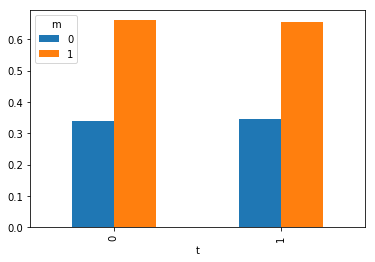

In [18]:
model_probabilities.plot.bar();